In [145]:
import pandas as pd

In [146]:
# 读取降雨径流数据
df = pd.read_csv("/Users/datou/PycharmProjects/model/JianyangSta/JY_data/建阳站日降雨径流蒸发资料(完整）.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
2000-03-04,95.218583,2.779
2000-03-05,111.431333,2.721
2000-03-06,92.994458,1.991
2000-03-07,90.252708,5.497
2000-03-08,86.227667,4.970
...,...,...
2018-10-26,39.116250,8.492
2018-10-27,46.711250,5.857
2018-10-28,70.970417,3.264


In [147]:
n_past=15

In [148]:
#划分数据
test_split = round(len(df) * 0.30)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_testing

,Q,P
Date,,
2013-03-12,78.960833,0.000
2013-03-13,77.579583,0.000
2013-03-14,75.796250,0.116
2013-03-15,83.706250,0.000
2013-03-16,86.175833,0.511
...,...,...
2018-10-26,39.116250,8.492
2018-10-27,46.711250,5.857
2018-10-28,70.970417,3.264


In [149]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [150]:
# 创建数据集 n_past: 时间步长
import numpy as np


def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [151]:
# 这里使用30，意味着将使用过去的30个值(包括目标列在内的所有特性)来预测第31个目标值。
trainX, trainY = createXY(df_for_training_scaled, n_past)
testX, testY = createXY(df_for_testing_scaled, n_past)
trainX.shape

(4756, 15, 2)

In [152]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers.core import Dense, Dropout, Activation


def build_model():
    """
    1、定义网络
    """
    grid_model = Sequential()  # 层次模型
    grid_model.add(layers.SimpleRNN(units=100, return_sequences=True))
    grid_model.add(Activation('relu'))
    grid_model.add(Dropout(0.1))
    grid_model.add(layers.SimpleRNN(units=100))
    grid_model.add(Dropout(0.1))
    grid_model.add(Dense(1))
    learning_rate = 3e-3
    """
    编译网络：编译需要指定许多参数，这些参数是专为培训网络而定制的。
    具体来说，用于训练网络和用于评估优化算法最小化的网络的优化算法。
    model.compile(optimizer,loss)
    """
    grid_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return grid_model

In [153]:
# 交叉搜索，寻求模型最佳参数，并输出最佳模型
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'batch_size': [16, 20],
              'epochs': [12, 16]}
"""
verbose参数设置为 2，可以将显示的信息量减小到每轮训练的损失。
可以通过将verbose设置为 1 来关闭所有输出
"""
grid_model = KerasRegressor(build_fn=build_model, verbose=1)
grid_search = GridSearchCV(estimator=grid_model,
                           param_grid=parameters,
                           cv=5)

/var/folders/p_/spnxgg1953n3fzj8z81sv51r0000gn/T/ipykernel_39046/2190303598.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1)


In [154]:
"""
训练网络
"""
grid_search = grid_search.fit(trainX, trainY)
# 将最佳模型保存在my_model变量中
my_model = grid_search.best_estimator_
# 使用测试数据集测试模型
"""
进行预测
"""
prediction = my_model.predict(testX)
prediction.shape

Epoch 1/12
238/238 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 2/12
238/238 [==============================] - 1s 3ms/step - loss: 7.4011e-04
Epoch 3/12
238/238 [==============================] - 1s 3ms/step - loss: 5.9289e-04
Epoch 4/12
238/238 [==============================] - 1s 3ms/step - loss: 5.6983e-04
Epoch 5/12
238/238 [==============================] - 1s 3ms/step - loss: 5.4662e-04
Epoch 6/12
238/238 [==============================] - 1s 3ms/step - loss: 5.0434e-04
Epoch 7/12
238/238 [==============================] - 1s 3ms/step - loss: 6.7374e-04
Epoch 8/12
238/238 [==============================] - 1s 3ms/step - loss: 5.5468e-04
Epoch 9/12
238/238 [==============================] - 1s 3ms/step - loss: 6.1233e-04
Epoch 10/12
238/238 [==============================] - 1s 3ms/step - loss: 5.6889e-04
Epoch 11/12
238/238 [==============================] - 1s 3ms/step - loss: 7.1649e-04
Epoch 12/12
60/60 [==============================] - 0s 1ms/step - 

(2044,)

In [155]:
"""
进行预测：训练集
"""
train_predict=my_model.predict(trainX)

298/298 [==============================] - 0s 705us/step


In [156]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 16}

In [157]:
# 逆缩放过程
# 改变形状来进行逆缩放，逆变换后的第一列是我们需要的，所以我们在最后使用了 → [:,0]。
prediction_copies_array = np.repeat(prediction, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), 2)))[:, 0]
pred

array([454.77277, 271.245  , 256.49213, ...,  73.89816,  77.04259,
        63.46448], dtype=float32)

In [158]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original

array([357.2854167 , 266.375     , 292.975     , ...,  70.97041667,
        64.49541667,  59.04125   ])

In [159]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4756,)

In [160]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4756,)

In [161]:
pred = pd.DataFrame(pred)
pred.columns = ['Qsim']
pred

,Qsim
0,454.772766
1,271.244995
2,256.492126
3,308.821289
4,243.782486
...,...
2039,44.966537
2040,80.538628
2041,73.898163
2042,77.042587


In [162]:
train_pred=pd.DataFrame(train_pred)
train_pred.columns=['Qsim']
train_pred

,Qsim
0,203.549225
1,100.399139
2,104.741852
3,101.354202
4,141.745255
...,...
4751,144.762939
4752,154.902802
4753,187.254364
4754,390.836182


In [163]:
original = pd.DataFrame(original)
original.columns = ['Qobs']
original

,Qobs
0,357.285417
1,266.375000
2,292.975000
3,279.295833
4,263.750000
...,...
2039,39.116250
2040,46.711250
2041,70.970417
2042,64.495417


In [164]:
train_original=pd.DataFrame(train_original)
train_original.columns=['Qobs']
train_original

,Qobs
0,146.646083
1,126.275542
2,116.957458
3,107.373583
4,157.025792
...,...
4751,179.575000
4752,254.883333
4753,518.239583
4754,342.933333


In [165]:
df_copy

,Date,Q,P
0,2000-03-04,95.218583,2.779
1,2000-03-05,111.431333,2.721
2,2000-03-06,92.994458,1.991
3,2000-03-07,90.252708,5.497
4,2000-03-08,86.227667,4.970
...,...,...,...
6810,2018-10-26,39.116250,8.492
6811,2018-10-27,46.711250,5.857
6812,2018-10-28,70.970417,3.264
6813,2018-10-29,64.495417,0.000


In [166]:
test_df=df_copy[-test_split:]
test_df

,Date,Q,P
4771,2013-03-27,357.285417,0.000
4772,2013-03-28,266.375000,5.566
4773,2013-03-29,292.975000,15.177
4774,2013-03-30,279.295833,7.662
4775,2013-03-31,263.750000,0.622
...,...,...,...
6810,2018-10-26,39.116250,8.492
6811,2018-10-27,46.711250,5.857
6812,2018-10-28,70.970417,3.264
6813,2018-10-29,64.495417,0.000


In [167]:
train_df=df_copy[n_past:-test_split]
train_df

,Date,Q,P
15,2000-03-19,146.646083,0.000
16,2000-03-20,126.275542,1.392
17,2000-03-21,116.957458,0.456
18,2000-03-22,107.373583,12.329
19,2000-03-23,157.025792,3.150
...,...,...,...
4766,2013-03-22,179.575000,0.000
4767,2013-03-23,254.883333,8.498
4768,2013-03-24,518.239583,30.304
4769,2013-03-25,342.933333,0.000


In [168]:
test_df = test_df.reset_index(drop=True)
test_df = test_df['Date']
test_df

0      2013-03-27
1      2013-03-28
2      2013-03-29
3      2013-03-30
4      2013-03-31
          ...    
2039   2018-10-26
2040   2018-10-27
2041   2018-10-28
2042   2018-10-29
2043   2018-10-30
Name: Date, Length: 2044, dtype: datetime64[ns]

In [169]:
train_df=train_df.reset_index(drop=True)
train_df=train_df['Date']
train_df

0      2000-03-19
1      2000-03-20
2      2000-03-21
3      2000-03-22
4      2000-03-23
          ...    
4751   2013-03-22
4752   2013-03-23
4753   2013-03-24
4754   2013-03-25
4755   2013-03-26
Name: Date, Length: 4756, dtype: datetime64[ns]

In [170]:
test_df_full=pd.concat([test_df,original,pred],axis=1)
test_df_full=test_df_full.reset_index(drop=True)
test_df_full=test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TestRNN.csv')
test_df_full

,Qobs,Qsim
Date,,
2013-03-27,357.285417,454.772766
2013-03-28,266.375000,271.244995
2013-03-29,292.975000,256.492126
2013-03-30,279.295833,308.821289
2013-03-31,263.750000,243.782486
...,...,...
2018-10-26,39.116250,44.966537
2018-10-27,46.711250,80.538628
2018-10-28,70.970417,73.898163


In [171]:
train_df_full=pd.concat([train_df,train_original,train_pred],axis=1)
train_df_full=train_df_full.reset_index(drop=True)
train_df_full=train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/JianyangSta/JY_data/JY_TrainRNN.csv')
train_df_full

,Qobs,Qsim
Date,,
2000-03-19,146.646083,203.549225
2000-03-20,126.275542,100.399139
2000-03-21,116.957458,104.741852
2000-03-22,107.373583,101.354202
2000-03-23,157.025792,141.745255
...,...,...
2013-03-22,179.575000,144.762939
2013-03-23,254.883333,154.902802
2013-03-24,518.239583,187.254364


MAE:53.29084377282113
RMSE:150.54251809115073
R2:0.7179505296247832
NSE:0.7179505296247835
RE:-15.009968680998726
Qmaxe:0.36093562786500505
Qmine:0.360167012981812


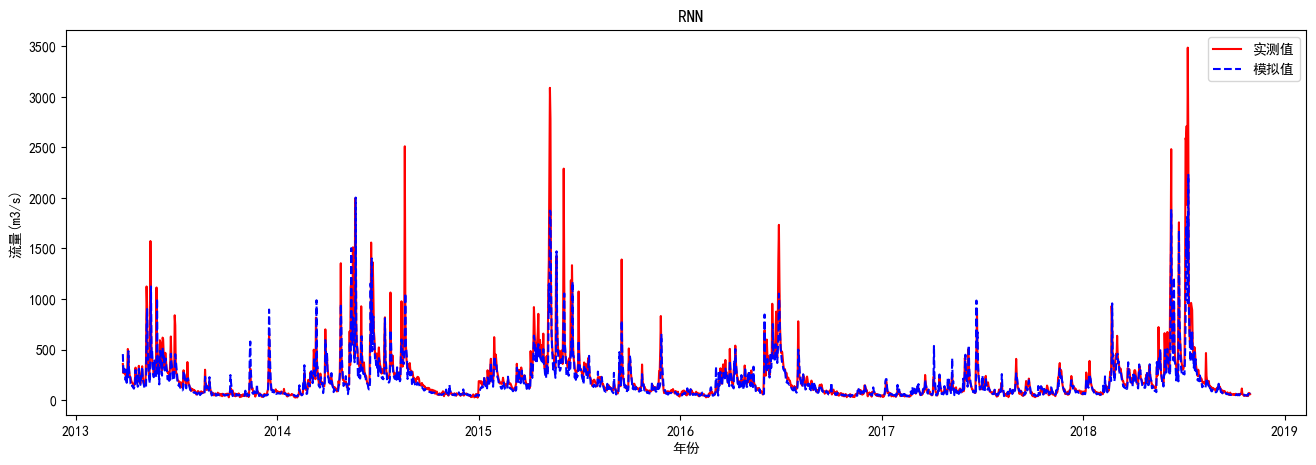

In [172]:
# 计算nash效率系数
from matplotlib import pyplot as plt
# 计算nash效率系数
from tool import Indicator

mae,rmse,r2,nse,re,qmaxe,qmine = Indicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(16,5))
plt.plot(test_df_full['Qobs'], color='red', label='实测值')
plt.plot(test_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' RNN' )
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TestRNN.png")
plt.show()

MAE:43.54568968693599
RMSE:129.27603583266668
R2:0.7535820304547132
NSE:0.7535820304547134
RE:-11.862753995633991
Qmaxe:0.402041108459522
Qmine:0.7982493162274017


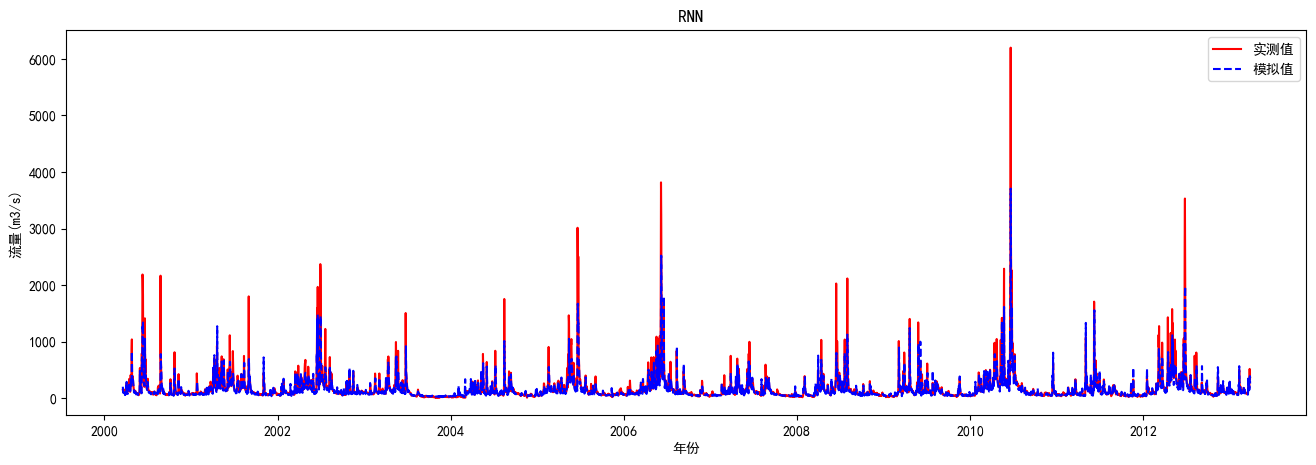

In [173]:
# 计算nash效率系数
train_mae,train_rmse,train_r2,train_nse,train_re,train_qmaxe,train_qmine = Indicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(16,5))
plt.plot(train_df_full['Qobs'], color='red', label='实测值')
plt.plot(train_df_full['Qsim'], color='blue', label='模拟值',linestyle="--")
plt.title(' RNN')
plt.xlabel('年份')
plt.ylabel('流量(m3/s)')
plt.legend()
plt.savefig("/Users/datou/PycharmProjects/model/JianyangSta/JY_picture/TrainRNN.png")
plt.show()

In [174]:
# 预测一些未来值
# 从主 df 数据集中获取我们在开始时加载的最后 30 个值
# df_past = df.iloc[-30:, :]
# # df_30_days_past.tail()
# df_future = pd.read_csv("test.csv", parse_dates=["Date"], index_col=[0])
# Qobs_future = df_future["Q"]
# # 剔除目标列
# df_future["Q"] = 0
# df_future = df_future[["Q", "P"]]
# df_past = df_past.values
# df_future

In [175]:
# 对数据进行缩放
# old_scaled_array = scaler.transform(df_past)
# new_scaled_array = scaler.transform(df_future)
# new_scaled_df = pd.DataFrame(new_scaled_array)
# new_scaled_df.iloc[:, 0] = np.nan
# full_df = pd.concat([pd.DataFrame(old_scaled_array), new_scaled_df]).reset_index().drop(["index"], axis=1)
# full_df

In [176]:
# # 使用特征值进行预测
# full_df_scaled_array = full_df.values
# all_data = []
# time_step = 30
# for i in range(time_step, len(full_df_scaled_array)):
#     data_x = []
#     data_x.append(
#         full_df_scaled_array[i - time_step:i, 0:full_df_scaled_array.shape[1]])
#     data_x = np.array(data_x)
#     prediction = my_model.predict(data_x)
#     all_data.append(prediction)
#     full_df.iloc[i, 0] = prediction

In [177]:
# 对预测进行逆变换
# new_array = np.array(all_data)
# new_array = new_array.reshape(-1, 1)
# prediction_copies_array = np.repeat(new_array, 2, axis=-1)
# y_pred_future = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(new_array), 2)))[:, 0]
# y_pred_future = pd.DataFrame(y_pred_future)
# y_pred_future

In [178]:
# Qobs_future = pd.DataFrame(Qobs_future)
# Qobs_future.reset_index(inplace=True)
# Qobs_future

In [179]:
# df_future_full = pd.concat([Qobs_future, y_pred_future], axis=1)
# df_future_full.columns = ['Date', "Qobs", "Qsim"]
# df_future_full.reset_index(drop=True)
# df_future_full = df_future_full.set_index('Date')
# df_future_full

In [180]:
# 绘图进行数据展示
# nash_futrue = evaluator.nash(df_future_full['Qsim'], df_future_full['Qobs'])
# plt.plot(df_future_full['Qsim'], color='green', label='Qsim')
# plt.plot(df_future_full['Qobs'], color='yellow', label='Qobs')
# plt.title('Verify Prediction-' + 'NSE: ' + format(nash_futrue, '.3f'))
# plt.xlabel('Time')
# plt.ylabel('Runoff(m3/s)')
# plt.legend()
# plt.show()